In [1]:
# prompt: connect to drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!unzip "/content/drive/MyDrive/Symbols.zip" -d "/content/Task-1"

Streaming output truncated to the last 5000 lines.
  inflating: /content/Task-1/images/v2-125468.png  
  inflating: /content/Task-1/images/v2-125509.png  
  inflating: /content/Task-1/images/v2-125634.png  
  inflating: /content/Task-1/images/v2-12571.png  
  inflating: /content/Task-1/images/v2-125871.png  
  inflating: /content/Task-1/images/v2-125995.png  
  inflating: /content/Task-1/images/v2-126125.png  
  inflating: /content/Task-1/images/v2-126514.png  
  inflating: /content/Task-1/images/v2-126555.png  
  inflating: /content/Task-1/images/v2-126757.png  
  inflating: /content/Task-1/images/v2-126888.png  
  inflating: /content/Task-1/images/v2-126935.png  
  inflating: /content/Task-1/images/v2-127283.png  
  inflating: /content/Task-1/images/v2-127479.png  
  inflating: /content/Task-1/images/v2-127588.png  
  inflating: /content/Task-1/images/v2-127767.png  
  inflating: /content/Task-1/images/v2-127808.png  
  inflating: /content/Task-1/images/v2-127844.png  
  inflating: /

In [4]:
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import cv2
import os
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

# Check if GPU is available in Colab and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class MLP:
    def __init__(self, input_size, hidden_layers, output_size, activation="relu",
                 learning_rate=0.01, optimizer="mini_batch_gd",weight_init="random"):
        """
        Initialize the Multi-Layer Perceptron.

        Parameters:
        -----------
        input_size : int
            Number of input features.
        hidden_layers : list
            List of integers specifying neurons in each hidden layer.
        output_size : int
            Number of output classes.
        activation : str
            Activation function for hidden layers ('relu', 'sigmoid', 'tanh').
        learning_rate : float
            Step size for gradient updates.
        optimizer : str
            Optimization method ('sgd', 'batch_gd', 'mini_batch_gd').
        weight_init : str
            Weight initialization method ('he', 'xavier', 'random').
        """
        self.learning_rate = learning_rate
        self.optimizer = optimizer
        self.activation = activation

        # Define network architecture
        self.layers = [input_size] + hidden_layers + [output_size]
        self.weights = []
        self.biases = []

        # Initialize weights and biases on the GPU
        for i in range(len(self.layers) - 1):
            if weight_init == "he":  # He initialization for ReLU
                scale = np.sqrt(2. / self.layers[i])
            elif weight_init == "xavier":  # Xavier for sigmoid/tanh
                scale = np.sqrt(1. / self.layers[i])
            else:  # Random initialization
                scale = 0.01
            weight = torch.randn(self.layers[i], self.layers[i+1], device=device) * scale
            bias = torch.zeros(1, self.layers[i+1], device=device)
            self.weights.append(weight)
            self.biases.append(bias)

    def forward(self, X):
        """Perform forward propagation through the network."""
        self.a = [X]  # Store activations, starting with input
        self.z = []   # Store pre-activation values

        # Process hidden layers
        for i in range(len(self.weights) - 1):
            z = torch.mm(self.a[-1], self.weights[i]) + self.biases[i]  # Linear transformation
            if self.activation == "relu":
                a = F.relu(z)
            elif self.activation == "sigmoid":
                a = torch.sigmoid(z)
            elif self.activation == "tanh":
                a = torch.tanh(z)
            self.z.append(z)
            self.a.append(a)

        # Output layer with softmax
        z_out = torch.mm(self.a[-1], self.weights[-1]) + self.biases[-1]
        a_out = F.softmax(z_out, dim=1)
        self.z.append(z_out)
        self.a.append(a_out)

        return a_out

    def backward(self, X, y):
        """Perform backward propagation to compute gradients."""
        m = X.shape[0]  # Number of samples
        gradients_w = []
        gradients_b = []

        # Gradient for output layer (softmax + cross-entropy)
        dz = self.a[-1] - y

        # Backpropagate through all layers
        for i in reversed(range(len(self.weights))):
            dw = torch.mm(self.a[i].T, dz) / m  # Weight gradient
            db = dz.sum(dim=0, keepdim=True) / m  # Bias gradient
            gradients_w.insert(0, dw)
            gradients_b.insert(0, db)

            if i > 0:  # Compute gradient for previous layer
                da = torch.mm(dz, self.weights[i].T)
                if self.activation == "relu":
                    dz = da * (self.a[i] > 0).float()
                elif self.activation == "sigmoid":
                    dz = da * self.a[i] * (1 - self.a[i])
                elif self.activation == "tanh":
                    dz = da * (1 - self.a[i]**2)

        return gradients_w, gradients_b

    def update_parameters(self, gradients_w, gradients_b):
        """Update weights and biases using gradients."""
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * gradients_w[i]
            self.biases[i] -= self.learning_rate * gradients_b[i]

    def compute_loss(self, y_true, y_pred):
        """Compute cross-entropy loss between true and predicted labels."""
        return F.cross_entropy(y_pred, y_true, reduction='mean')

    def train(self, X_train, y_train, epochs=10, batch_size=32, verbose=True):
        """Train the MLP using the specified optimizer."""
        n_samples = X_train.shape[0]

        for epoch in range(epochs):
            total_loss = 0

            if self.optimizer == "batch_gd":
                # Full batch gradient descent
                y_pred = self.forward(X_train)
                loss = self.compute_loss(y_train, y_pred)
                gradients_w, gradients_b = self.backward(X_train, y_train)
                self.update_parameters(gradients_w, gradients_b)
                total_loss = loss.item()

            elif self.optimizer == "mini_batch_gd":
                # Mini-batch gradient descent
                indices = torch.randperm(n_samples)
                n_batches = 0

                for i in range(0, n_samples, batch_size):
                    batch_indices = indices[i:i + batch_size]
                    X_batch = X_train[batch_indices]
                    y_batch = y_train[batch_indices]

                    y_pred = self.forward(X_batch)
                    loss = self.compute_loss(y_batch, y_pred)
                    gradients_w, gradients_b = self.backward(X_batch, y_batch)
                    self.update_parameters(gradients_w, gradients_b)
                    total_loss += loss.item()
                    n_batches += 1

                total_loss /= n_batches

            elif self.optimizer == "sgd":
                # Stochastic gradient descent
                indices = torch.randperm(n_samples)
                for i in indices:
                    X_sample = X_train[i:i+1]
                    y_sample = y_train[i:i+1]

                    y_pred = self.forward(X_sample)
                    loss = self.compute_loss(y_sample, y_pred)
                    gradients_w, gradients_b = self.backward(X_sample, y_sample)
                    self.update_parameters(gradients_w, gradients_b)
                    total_loss += loss.item()
                total_loss /= n_samples

            if verbose:  # Print loss if verbose is True
                print(f"Epoch {epoch}: Loss = {total_loss:.4f}")

    def predict(self, X):
        """Predict class labels for input data."""
        with torch.no_grad():  # Disable gradient tracking for faster inference
            y_pred = self.forward(X)
            return torch.argmax(y_pred, dim=1)

def load_data(csv_path):
    """Load and preprocess image data from a CSV file."""
    df = pd.read_csv(csv_path)
    images = []
    labels = df["symbol_id"].values

    for img_path in df["path"]:
        # Modify the image path
        modified_path = os.path.join("/content/Task-1/", img_path.lstrip("../"))
        try:
            img = cv2.imread(modified_path, cv2.IMREAD_GRAYSCALE)  # Remove 'images' prefix
            if img is None:
                raise FileNotFoundError(f"Image not found: {modified_path}")
            img = cv2.resize(img, (32, 32)).flatten() / 255.0  # Resize and normalize
            images.append(img)
        except Exception as e:
            print(f"Error loading {modified_path}: {e}")
            continue

    return np.array(images), labels

Using device: cuda


In [5]:
# Load training and test data
X_train, y_train = load_data("/content/Task-1/classification-task/fold-1/train.csv")
X_test, y_test = load_data("/content/Task-1/classification-task/fold-1/test.csv")

# Convert labels to one-hot encoding
encoder = OneHotEncoder(sparse_output=False)
y_train = encoder.fit_transform(y_train.reshape(-1, 1))
y_test = encoder.transform(y_test.reshape(-1, 1))

# Convert data to PyTorch tensors and move to GPU
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

# Initialize MLP model
mlp = MLP(
  input_size=32*32,  # 1024 features from 32x32 images
  hidden_layers=[1024, 512],  # Two hidden layers
  output_size=len(encoder.categories_[0]),  # Number of unique classes
  activation="relu",
  learning_rate=0.05,
  optimizer="mini_batch_gd",
)

# Train the model
mlp.train(X_train, y_train, epochs=10, batch_size=32, verbose=True)

# Evaluate on test data
y_pred = mlp.predict(X_test).cpu().numpy()  # Move predictions back to CPU for sklearn
y_test_labels = torch.argmax(y_test, dim=1).cpu().numpy()
accuracy = accuracy_score(y_test_labels, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 0: Loss = 5.7190
Epoch 1: Loss = 5.4407
Epoch 2: Loss = 5.3551
Epoch 3: Loss = 5.3072
Epoch 4: Loss = 5.2772
Epoch 5: Loss = 5.2535
Epoch 6: Loss = 5.2361
Epoch 7: Loss = 5.2200
Epoch 8: Loss = 5.2068
Epoch 9: Loss = 5.1958
Test Accuracy: 0.7483


Using device: cuda
Fold: fold-1, Activation: relu, Optimizer: mini_batch_gd, LR: 0.01, Batch: 32, Accuracy: 0.6966
Fold: fold-1, Activation: relu, Optimizer: batch, LR: 0.01, Batch: 32, Accuracy: 0.0015
Fold: fold-1, Activation: relu, Optimizer: sgd, LR: 0.01, Batch: 32, Accuracy: 0.4602
Fold: fold-1, Activation: sigmoid, Optimizer: mini_batch_gd, LR: 0.01, Batch: 32, Accuracy: 0.0207
Fold: fold-1, Activation: sigmoid, Optimizer: batch, LR: 0.01, Batch: 32, Accuracy: 0.0063
Fold: fold-1, Activation: sigmoid, Optimizer: sgd, LR: 0.01, Batch: 32, Accuracy: 0.6143
Fold: fold-1, Activation: tanh, Optimizer: mini_batch_gd, LR: 0.01, Batch: 32, Accuracy: 0.5064
Fold: fold-1, Activation: tanh, Optimizer: batch, LR: 0.01, Batch: 32, Accuracy: 0.0002
Fold: fold-1, Activation: tanh, Optimizer: sgd, LR: 0.01, Batch: 32, Accuracy: 0.3788
Fold: fold-2, Activation: relu, Optimizer: mini_batch_gd, LR: 0.01, Batch: 32, Accuracy: 0.5204
Fold: fold-2, Activation: relu, Optimizer: batch, LR: 0.01, Batch:

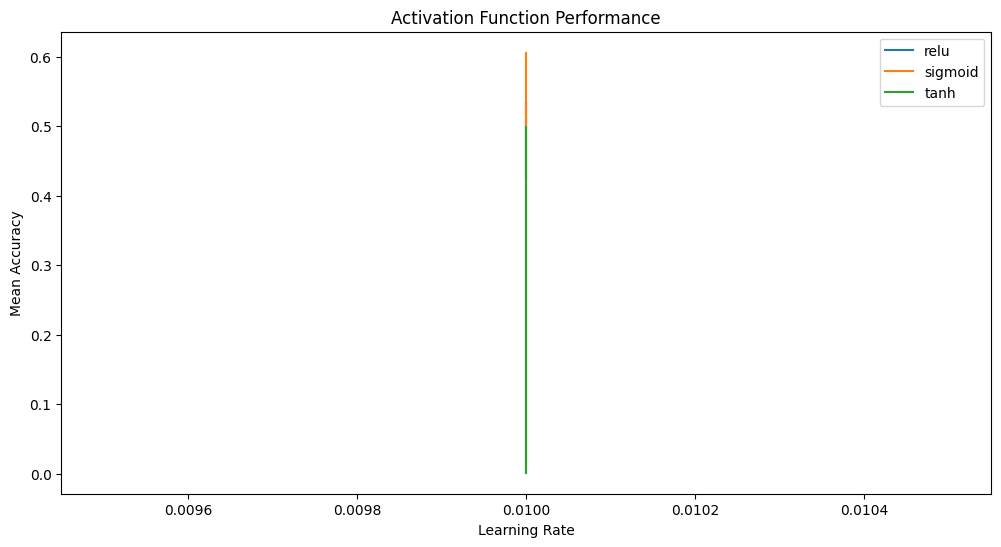

In [6]:
#Hyper parameter tuning..
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define hyperparameter tuning function
def hyperparameter_tuning(folds, activations, optimizers, learning_rates, batch_sizes, epochs=10):
    results = []

    for fold in folds:
        X_train, y_train = load_data(fold['train'])
        X_test, y_test = load_data(fold['test'])

        encoder = OneHotEncoder(sparse_output=False)
        y_train = encoder.fit_transform(y_train.reshape(-1, 1))
        y_test = encoder.transform(y_test.reshape(-1, 1))

        X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
        y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
        X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
        y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

        for activation in activations:
            for optimizer in optimizers:
                for lr in learning_rates:
                    for batch_size in batch_sizes:
                        mlp = MLP(
                            input_size=32*32,
                            hidden_layers=[1024, 512],
                            output_size=len(encoder.categories_[0]),
                            activation=activation,
                            learning_rate=lr,
                            optimizer=optimizer,
                        )
                        if(optimizer == "sgd"):
                            epochs=3
                        mlp.train(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=False)
                        y_pred = mlp.predict(X_test).cpu().numpy()
                        y_test_labels = torch.argmax(y_test, dim=1).cpu().numpy()
                        accuracy = accuracy_score(y_test_labels, y_pred)
                        results.append({
                            "fold": fold['name'], "activation": activation, "optimizer": optimizer,
                            "learning_rate": lr, "batch_size": batch_size, "accuracy": accuracy
                        })
                        print(f"Fold: {fold['name']}, Activation: {activation}, Optimizer: {optimizer}, LR: {lr}, Batch: {batch_size}, Accuracy: {accuracy:.4f}")

    df_results = pd.DataFrame(results)
    mean_std_results = df_results.groupby(["activation", "optimizer", "learning_rate", "batch_size"])['accuracy'].agg(['mean', 'std']).reset_index()
    print(mean_std_results.sort_values(by='mean', ascending=False))
    return mean_std_results

# Load data folds
folds = [
    {"name": f"fold-{i}", "train": f"/content/Task-1/classification-task/fold-{i}/train.csv", "test": f"/content/Task-1/classification-task/fold-{i}/test.csv"} for i in range(1, 11)
]

# Define hyperparameter search space
activations = ["relu", "sigmoid", "tanh"]
optimizers = ["mini_batch_gd","batch","sgd"]
learning_rates = [0.01]
batch_sizes = [32]

# Run hyperparameter tuning
results_df = hyperparameter_tuning(folds, activations, optimizers, learning_rates, batch_sizes, epochs=10)

# Plot results
plt.figure(figsize=(12, 6))
for activation in activations:
    subset = results_df[results_df['activation'] == activation]
    plt.plot(subset['learning_rate'], subset['mean'], label=f"{activation}")
plt.xlabel('Learning Rate')
plt.ylabel('Mean Accuracy')
plt.title('Activation Function Performance')
plt.legend()
plt.show()


<ipython-input-12-760a5f97b363>:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='activation_optimizer', y='mean', data=results_df, ci=None, palette="viridis")
<ipython-input-12-760a5f97b363>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='activation_optimizer', y='mean', data=results_df, ci=None, palette="viridis")


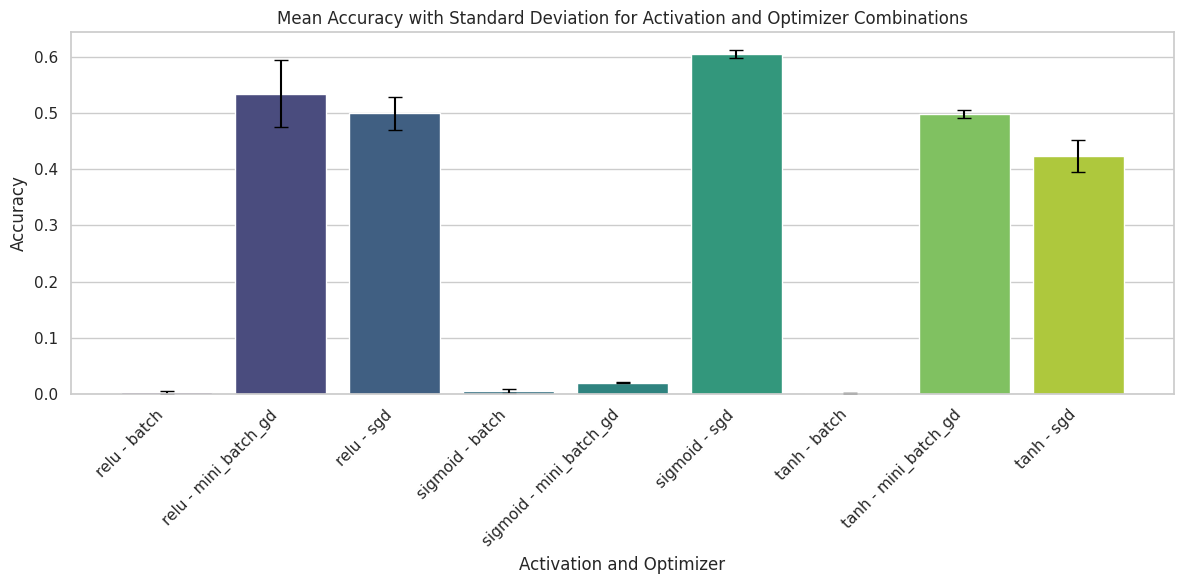

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming results_df is already defined in your environment

# Combine activation and optimizer for a grouped x-axis
results_df['activation_optimizer'] = results_df['activation'] + ' - ' + results_df['optimizer']

# Set plot style
sns.set(style="whitegrid")

# Plot the graph
plt.figure(figsize=(12, 6))

# Plot the mean accuracies as bars
sns.barplot(x='activation_optimizer', y='mean', data=results_df, ci=None, palette="viridis")

# Add error bars for the standard deviation
for index, row in results_df.iterrows():
    plt.errorbar(index, row['mean'], yerr=row['std'], fmt='none', c='black', capsize=5)

# Title and labels
plt.title('Mean Accuracy with Standard Deviation for Activation and Optimizer Combinations')
plt.xlabel('Activation and Optimizer')
plt.ylabel('Accuracy')

# Rotate x-axis labels for readability
plt.xticks(rotation=45, ha="right")

# Show the plot
plt.tight_layout()
plt.show()


Final Test Performance
You already calculate and print the final test accuracy for each configuration. To visualize it, you can use a similar bar plot as for accuracy trends, but focusing on the 'accuracy' column of mean_std_results.

Report Questions
1. What do the mean and standard deviation tell you about model performance and consistency?

- Mean: Represents the average accuracy across all folds for a specific hyperparameter configuration. It indicates the overall performance level of the model.
- Standard Deviation: Measures the variability or spread of accuracy values across folds. A low standard deviation suggests the model is consistent in its performance, while a high standard deviation indicates greater variability.
2. How does a high vs. low standard deviation impact confidence in the model’s generalization?

- High Standard Deviation: Indicates the model's performance is highly dependent on the specific data in each fold. This reduces confidence in its ability to generalize well to unseen data.
- Low Standard Deviation: Shows the model is less sensitive to data variations and is likely to perform similarly on new data, increasing confidence in its generalization ability.
3. If one configuration has a slightly higher mean accuracy but a significantly higher standard deviation compared to another with marginally lower mean accuracy, which would you choose and why?

- Generally, we would choose the configuration with marginally lower mean accuracy but significantly lower standard deviation. This is because a lower standard deviation indicates better generalization and robustness. While the slightly higher mean accuracy might be tempting, the higher variability suggests that the model's performance is less predictable and might not perform as well on unseen data.